In [731]:
# 노트북 전체에서 한글이 무난히 보이도록 macOS 기본 한글 폰트로 강제 설정합니다
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns
import warnings
import plotly.express as px
import numpy as np
warnings.filterwarnings('ignore')
# 우선 macOS에서 일반적으로 잘 동작하는 폰트를 지정합니다
preferred = ['Apple SD Gothic Neo', 'AppleGothic', 'NanumGothic', 'Noto Sans KR']
set_name = None
for name in preferred:
    try:
        mpl.rc('font', family=name)
        mpl.rcParams['axes.unicode_minus'] = False
        sns.set(rc={'font.family': name})
        set_name = name
        break
    except Exception:
        set_name = None
if set_name:
    print('한글 폰트로 설정됨:', set_name)
else:
    print('선택한 기본 폰트들이 시스템에 없거나 설정에 실패했습니다. 후보 폰트 목록을 확인해 수동 설정하세요.')
    # 후보 목록 출력(도움)
    candidates = ['nanum','noto','apple','gothic','malgun','batang']
    system_fonts = fm.findSystemFonts()
    for f in system_fonts:
        try:
            n = fm.FontProperties(fname=f).get_name()
        except Exception:
            continue
        low = (n + ' ' + f).lower()
        if any(k in low for k in candidates):
            print(n, '->', f)

한글 폰트로 설정됨: Apple SD Gothic Neo


In [732]:
import pandas as pd
korean = pd.read_csv('data/korean.csv', header=None)
foreigner = pd.read_csv('data/foreigner.csv', header=None)

In [733]:
# 내국인 수의 df 정렬

# 쓸모 없는 행, 열 1차 제거
korean.drop([0, 1, 2], axis=0, inplace=True)
korean.drop([0], axis=1, inplace=True)

# 행, 열 인덱스 재설정
korean = korean.reset_index(drop=True)
korean.columns = range(korean.shape[1])

# 반복문을 이용해 연도별 인구수만 남기고 나머지 열 제거
for i in range(1, len(korean.columns)):
    if i % 6 == 1:
        continue
    korean.drop([i], axis=1, inplace=True)

# 행 인덱스 재설정
korean.index = korean[0].str.strip() # 공백 제거 후 행 인덱스로 설정
korean.drop([0], axis=1, inplace=True)
korean.columns = [str(i)+'년' for i in range(2015, 2021)]

korean.drop('세종특별자치시', axis=0, inplace=True)


for i in range(len(korean)):
    for j in range(len(korean.columns)):
        v = korean.iloc[i, j]
        if pd.isna(v):
            continue
        v = str(v).replace(',', '').strip()
        if v == '':
            korean.iloc[i, j] = 0
        else:
            korean.iloc[i, j] = int(v)
korean

,2015년,2016년,2017년,2018년,2019년,2020년
0,,,,,,
전국,51529338,51696216,51778544,51826059,51849861,51829023
서울특별시,10022181,9930616,9857426,9765623,9729107,9668465
부산광역시,3513777,3498529,3470653,3441453,3413841,3391946
대구광역시,2487829,2484557,2475231,2461769,2438031,2418346
인천광역시,2925815,2943069,2948542,2954642,2957026,2942828
광주광역시,1472199,1469214,1463770,1459336,1456468,1450062
대전광역시,1518775,1514370,1502227,1489936,1474870,1463882
울산광역시,1173534,1172304,1165132,1155623,1148019,1136017
경기도,12522606,12716780,12873895,13077153,13239666,13427014


In [734]:
# 외국인 수의 df 정렬

# 쓸모 없는 행, 열 1차 제거
foreigner.drop([0, 1], axis=0, inplace=True)
foreigner.reset_index(drop=True, inplace=True)

# 17개 단위로 반복되는 행 중 첫 번째 행(각 연령별 합계)만 남기고 나머지 행 제거
for i in range(foreigner.shape[0]):
    if i % 17 != 0:
        foreigner.drop([i], axis=0, inplace=True)
    continue
# 행 인덱스 재설정
foreigner.reset_index(drop=True, inplace=True)
foreigner.drop([1, 2, 3, 11], axis=0, inplace=True)
foreigner.reset_index(drop=True, inplace=True)

# 열 인덱스 재설정
foreigner.drop([1], axis=1, inplace=True)
foreigner.index = foreigner[0].str.strip() # 공백 제거 후 행 인덱스로 설정
foreigner.drop([0], axis=1, inplace=True)
foreigner.columns = range(foreigner.shape[1])

# 반복문을 이용해 남녀 합만 남기고 나머지 열 제거
for i in range(foreigner.shape[1]):
    if i % 3 == 0:
        continue
    foreigner.drop([i], axis=1, inplace=True)

# 행 인덱스 재설정
foreigner.columns = range(foreigner.shape[1])
foreigner.columns = [str(i)+'년' for i in range(2015, 2021)]

for i in range(len(foreigner)):
    for j in range(len(foreigner.columns)):
        v = foreigner.iloc[i, j]
        if pd.isna(v):
            continue
        v = str(v).replace(',', '').strip()
        if v == '':
            foreigner.iloc[i, j] = 0
        else:
            foreigner.iloc[i, j] = int(v)

foreigner

,2015년,2016년,2017년,2018년,2019년,2020년
0,,,,,,
전국,1363712,1413758,1479247,1651561,1778918,1695643
서울특별시,337116,335167,343927,374425,390177,366454
부산광역시,44070,46168,48808,55506,60502,54914
대구광역시,29282,30492,31365,35280,40092,37398
인천광역시,67850,71873,79170,88489,100174,99212
광주광역시,21592,23701,26052,29833,33286,30573
대전광역시,19080,19687,20534,22858,25147,22928
울산광역시,29860,28792,26601,27162,28604,26895
경기도,452632,472699,497089,558197,594795,583462


In [735]:
# 연도별, 지역별 범죄 수 데이터프레임 생성
# 경찰청에서 배포한 pdf 파일을 보고 하드 코딩
value = {
    '2015년': [1834836, 356575, 140700, 98897, 99915, 61234, 49593, 44569, 430790, 56928, 53703, 73409, 57342, 66643, 91876, 118843, 33819 ],
    '2016년': [1819014, 343104, 129211, 86150, 100387, 54271, 49038, 39799, 476348, 58814, 56179, 72072, 53375, 62794, 88059, 114410, 35003],
    '2017년': [1636131, 320193, 116449, 75016, 91385, 48213, 46988, 34912, 417066, 53171, 50387, 67276, 48979, 53892, 80061, 100775, 31368],
    '2018년': [1542267, 308997, 110628, 72341, 86391, 43569, 45527, 32764, 388938, 45233, 48315, 68577, 47944, 50993, 74356, 90267, 27427],
    '2019년': [1568968, 309269, 113138, 75797, 90608, 44274, 45167, 32780, 394276, 46096, 48085, 62666, 48252, 52698, 77449, 96212, 26090],
    '2020년': [1542270, 296178, 113652, 72373, 88143, 43517, 44623, 31381, 394226, 44571, 47864, 61612, 47446, 51519, 73762, 97998, 27129]
}

row = [
    '전국', '서울특별시', '부산광역시', '대구광역시', '인천광역시', '광주광역시', '대전광역시', '울산광역시',
    '경기도', '강원도', '충청북도', '충청남도', '전라북도', '전라남도', '경상북도', '경상남도', '제주특별자치도'
]

column = ['2015년', '2016년', '2017년', '2018년', '2019년', '2020년']
criminal = pd.DataFrame(value, index=row, columns=column)

criminal

,2015년,2016년,2017년,2018년,2019년,2020년
전국,1834836,1819014,1636131,1542267,1568968,1542270
서울특별시,356575,343104,320193,308997,309269,296178
부산광역시,140700,129211,116449,110628,113138,113652
대구광역시,98897,86150,75016,72341,75797,72373
인천광역시,99915,100387,91385,86391,90608,88143
광주광역시,61234,54271,48213,43569,44274,43517
대전광역시,49593,49038,46988,45527,45167,44623
울산광역시,44569,39799,34912,32764,32780,31381
경기도,430790,476348,417066,388938,394276,394226
강원도,56928,58814,53171,45233,46096,44571


In [736]:
# 연도별, 지역별 외국인 비율
value = {
    '2015년': [i for i in (foreigner['2015년'] / (korean['2015년'] + foreigner['2015년']) * 100)],
    '2016년': [i for i in (foreigner['2016년'] / (korean['2016년'] + foreigner['2016년']) * 100)],
    '2017년': [i for i in (foreigner['2017년'] / (korean['2017년'] + foreigner['2017년']) * 100)],
    '2018년': [i for i in (foreigner['2018년'] / (korean['2018년'] + foreigner['2018년']) * 100)],
    '2019년': [i for i in (foreigner['2019년'] / (korean['2019년'] + foreigner['2019년']) * 100)],
    '2020년': [i for i in (foreigner['2020년'] / (korean['2020년'] + foreigner['2020년']) * 100)]
}

row = [
    '전국', '서울특별시', '부산광역시', '대구광역시', '인천광역시', '광주광역시', '대전광역시', '울산광역시',
    '경기도', '강원도', '충청북도', '충청남도', '전라북도', '전라남도', '경상북도', '경상남도', '제주특별자치도'
]

column = ['2015년', '2016년', '2017년', '2018년', '2019년', '2020년']

foreignerPercent = pd.DataFrame(value, index=row, columns=column)

print(foreignerPercent)

# 연도별, 지역별 범죄율
value = {
    '2015년': [i for i in (criminal['2015년'] / (korean['2015년'] + foreigner['2015년']) * 100)],
    '2016년': [i for i in (criminal['2016년'] / (korean['2016년'] + foreigner['2016년']) * 100)],
    '2017년': [i for i in (criminal['2017년'] / (korean['2017년'] + foreigner['2017년']) * 100)],
    '2018년': [i for i in (criminal['2018년'] / (korean['2018년'] + foreigner['2018년']) * 100)],
    '2019년': [i for i in (criminal['2019년'] / (korean['2019년'] + foreigner['2019년']) * 100)],
    '2020년': [i for i in (criminal['2020년'] / (korean['2020년'] + foreigner['2020년']) * 100)]
}
criminalPercent = pd.DataFrame(value, index=row, columns=column)

print(criminalPercent)

# 1. 기존 행 인덱스를 'region' 열로 변환
# 2. melt로 long-format 변환
cp_long = criminalPercent.reset_index().rename(columns={'index':'region'})
cp_long = cp_long.melt(id_vars='region', var_name='year', value_name='criminal_percent')

# 연도 숫자 추출(정렬용)
cp_long['year_num'] = cp_long['year'].astype(str).str.extract(r'(\d{4})').astype(int)



            2015년     2016년     2017년     2018년     2019년     2020년
전국       2.578244  2.661944  2.777522  3.088322  3.317096  3.167966
서울특별시    3.254236  3.264895  3.371386  3.692537  3.855777  3.651788
부산광역시    1.238670  1.302453  1.386803  1.587265  1.741394  1.593160
대구광역시    1.163318  1.212382  1.251299  1.412868  1.617837  1.522879
인천광역시    2.266453  2.383893  2.614846  2.907827  3.276658  3.261364
광주광역시    1.445450  1.587565  1.748665  2.003332  2.234329  2.064857
대전광역시    1.240689  1.283329  1.348472  1.510979  1.676448  1.542093
울산광역시    2.481315  2.397144  2.232127  2.296444  2.431025  2.312729
경기도      3.488429  3.583910  3.717670  4.093749  4.299372  4.164470
강원도      1.167614  1.233242  1.336356  1.540900  1.721889  1.572829
충청북도     2.508632  2.743678  2.936502  3.315122  3.601841  3.443690
충청남도     3.308092  3.565949  3.849700  4.312908  4.669244  4.466545
전라북도     1.575561  1.663678  1.787996  2.085915  2.359791  2.294432
전라남도     1.780761  1.887615  1.924457  2.208269 

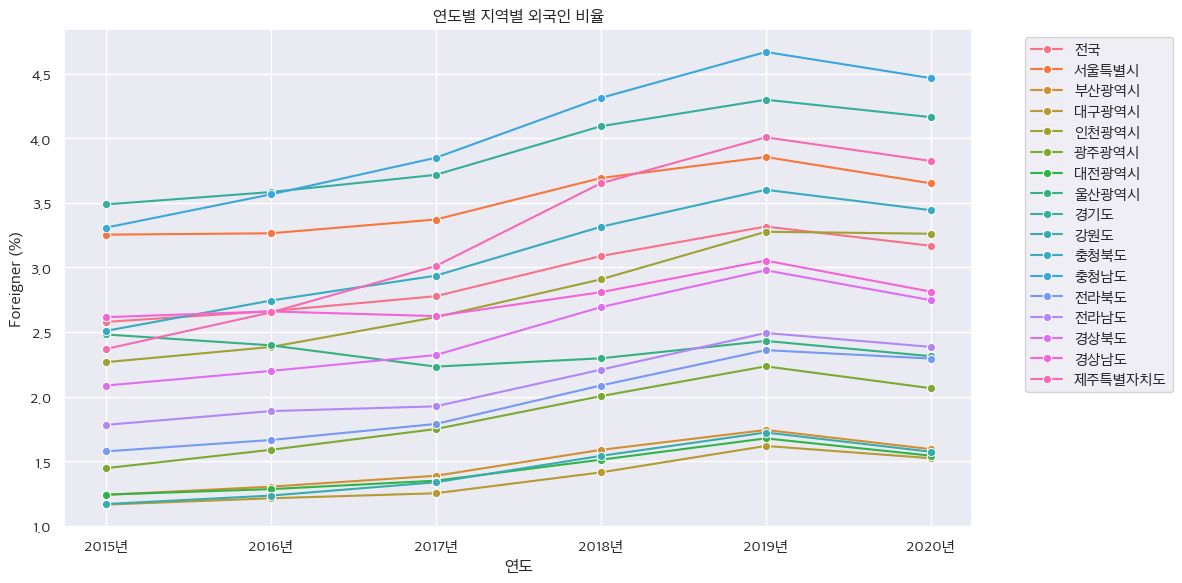

In [737]:
# line plot: 연도 변화에 따른 지역별 외국인 비율
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. 기존 행 인덱스를 'region' 열로 변환
# 2. melt로 long-format 변환
cm_long = foreignerPercent.reset_index().rename(columns={'index':'region'})
cm_long = cm_long.melt(id_vars='region', var_name='year', value_name='foreigner_pct')

# 연도 숫자 추출(정렬용)
cm_long['year_num'] = cm_long['year'].astype(str).str.extract(r'(\d{4})').astype(int)

# (선택) 그릴 지역 목록 — 주석 해제하고 원하는 지역만 넣으면 됨
# regions_to_plot = ['서울특별시','경기도','부산광역시']
# fp_long = fp_long[fp_long['region'].isin(regions_to_plot)]

# Plot: x=year_num, y=foreigner_pct, hue=region
plt.figure(figsize=(12,6))
sns.lineplot(data=cm_long, x='year_num', y='foreigner_pct', hue='region', marker='o')
plt.xticks(cm_long['year_num'].sort_values().unique(), [str(y)+'년' for y in cm_long['year_num'].sort_values().unique()])
plt.xlabel('연도')
plt.ylabel('Foreigner (%)')
plt.title('연도별 지역별 외국인 비율')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


# 데이터 확인
# display(fp_long.head(20))

      region   year  foreigner_pct
0         전국  2015년       2.578244
1      서울특별시  2015년       3.254236
2      부산광역시  2015년       1.238670
3      대구광역시  2015년       1.163318
4      인천광역시  2015년       2.266453
5      광주광역시  2015년       1.445450
6      대전광역시  2015년       1.240689
7      울산광역시  2015년       2.481315
8        경기도  2015년       3.488429
9        강원도  2015년       1.167614
10      충청북도  2015년       2.508632
11      충청남도  2015년       3.308092
12      전라북도  2015년       1.575561
13      전라남도  2015년       1.780761
14      경상북도  2015년       2.085393
15      경상남도  2015년       2.615321
16   제주특별자치도  2015년       2.368261
17        전국  2016년       2.661944
18     서울특별시  2016년       3.264895
19     부산광역시  2016년       1.302453
20     대구광역시  2016년       1.212382
21     인천광역시  2016년       2.383893
22     광주광역시  2016년       1.587565
23     대전광역시  2016년       1.283329
24     울산광역시  2016년       2.397144
25       경기도  2016년       3.583910
26       강원도  2016년       1.233242
27      충청북도  2016년 

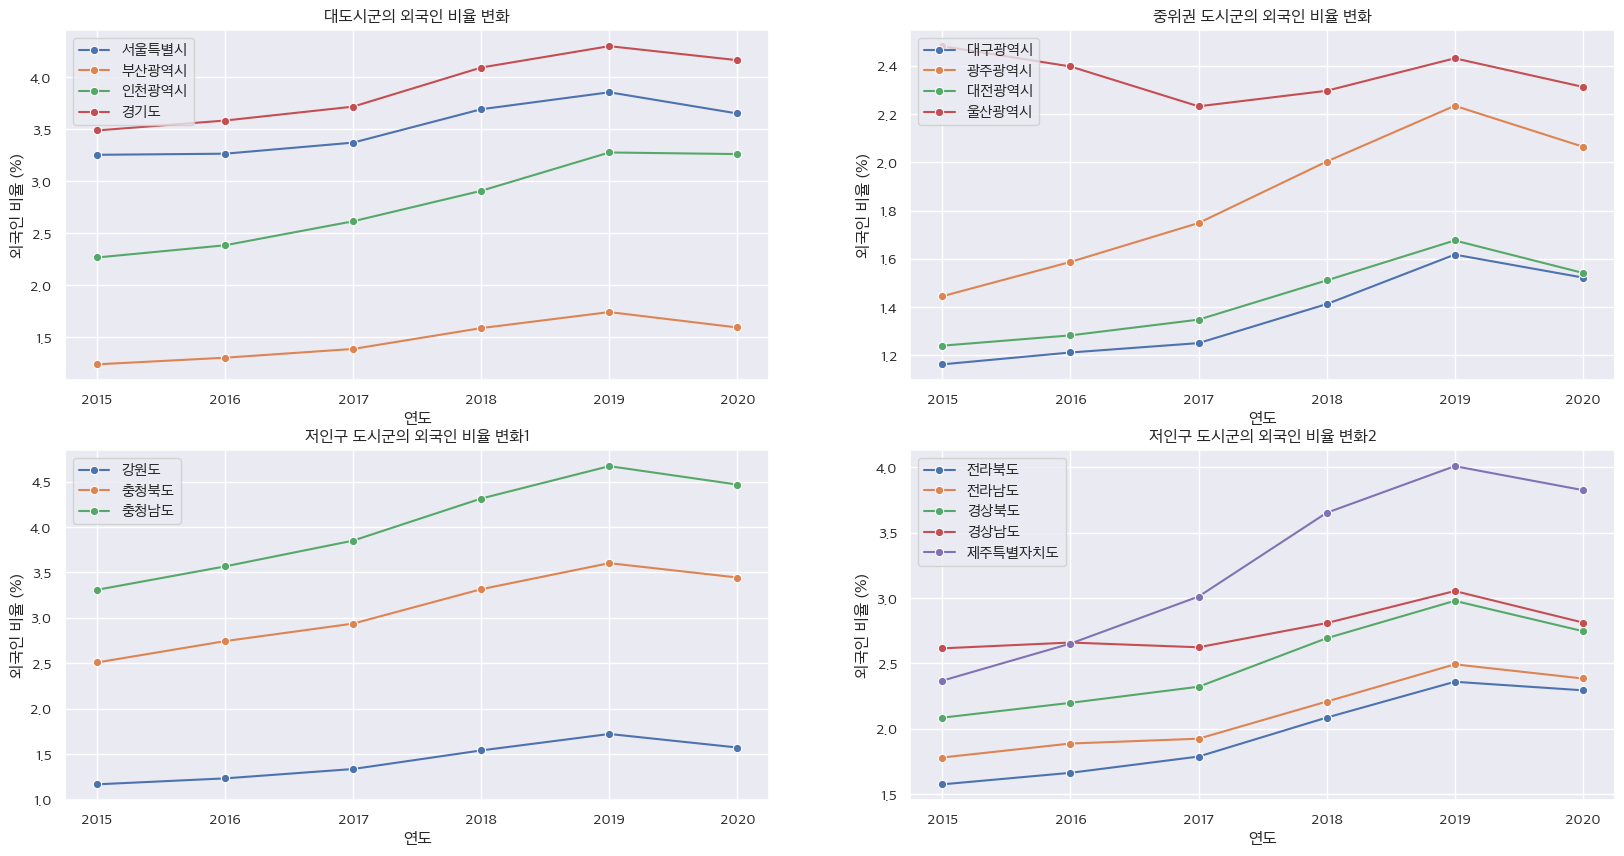

In [738]:
# line plot: 지역별 연도 변화에 따른 외국인 비율
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. 기존 행 인덱스를 'region' 열로 변환
# 2. melt로 long-format 변환
cm_long = foreignerPercent.reset_index().rename(columns={'index':'region'})
cm_long = cm_long.melt(id_vars='region', var_name='year', value_name='foreigner_pct')
print(cm_long)
# 연도 숫자 추출(정렬용)
cm_long['year_num'] = cm_long['year'].astype(str).str.extract(r'(\d{4})').astype(int)

# (선택) 그릴 지역 목록 — 주석 해제하고 원하는 지역만 넣으면 됨
# regions_to_plot = ['서울특별시','경기도','부산광역시']
# fp_long = fp_long[fp_long['region'].isin(regions_to_plot)]

# Plot: x=year_num, y=foreigner_pct, hue=region
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

# 첫 번째 그래프
regions_to_plot = ['서울특별시','경기도','부산광역시', '인천광역시']
cm_long1 = cm_long[cm_long['region'].isin(regions_to_plot)]
sns.lineplot(data=cm_long1, x='year_num', y='foreigner_pct', hue='region', marker='o', ax=ax1)
ax1.set_title('대도시군의 외국인 비율 변화')
ax1.set_xlabel('연도')
ax1.set_ylabel('외국인 비율 (%)')
ax1.legend(loc='upper left')

# 두 번째 그래프
regions_to_plot = ['대구광역시','광주광역시','대전광역시', '울산광역시']
cm_long2 = cm_long[cm_long['region'].isin(regions_to_plot)]
sns.lineplot(data=cm_long2, x='year_num', y='foreigner_pct', hue='region', marker='o', ax=ax2)
ax2.set_title('중위권 도시군의 외국인 비율 변화')
ax2.set_xlabel('연도')
ax2.set_ylabel('외국인 비율 (%)')
ax2.legend(loc='upper left')

# 세 번째 그래프
regions_to_plot = ['강원도','충청북도','충청남도']
cm_long3 = cm_long[cm_long['region'].isin(regions_to_plot)]
sns.lineplot(data=cm_long3, x='year_num', y='foreigner_pct', hue='region', marker='o', ax=ax3)
ax3.set_title('저인구 도시군의 외국인 비율 변화1')
ax3.set_xlabel('연도')
ax3.set_ylabel('외국인 비율 (%)')
ax3.legend(loc='upper left')

# 네 번째 그래프
regions_to_plot = ['전라북도','전라남도','경상북도','경상남도', '제주특별자치도']
cm_long4 = cm_long[cm_long['region'].isin(regions_to_plot)]
sns.lineplot(data=cm_long4, x='year_num', y='foreigner_pct', hue='region', marker='o', ax=ax4)
ax4.set_title('저인구 도시군의 외국인 비율 변화2')
ax4.set_xlabel('연도')
ax4.set_ylabel('외국인 비율 (%)')
ax4.legend(loc='upper left')


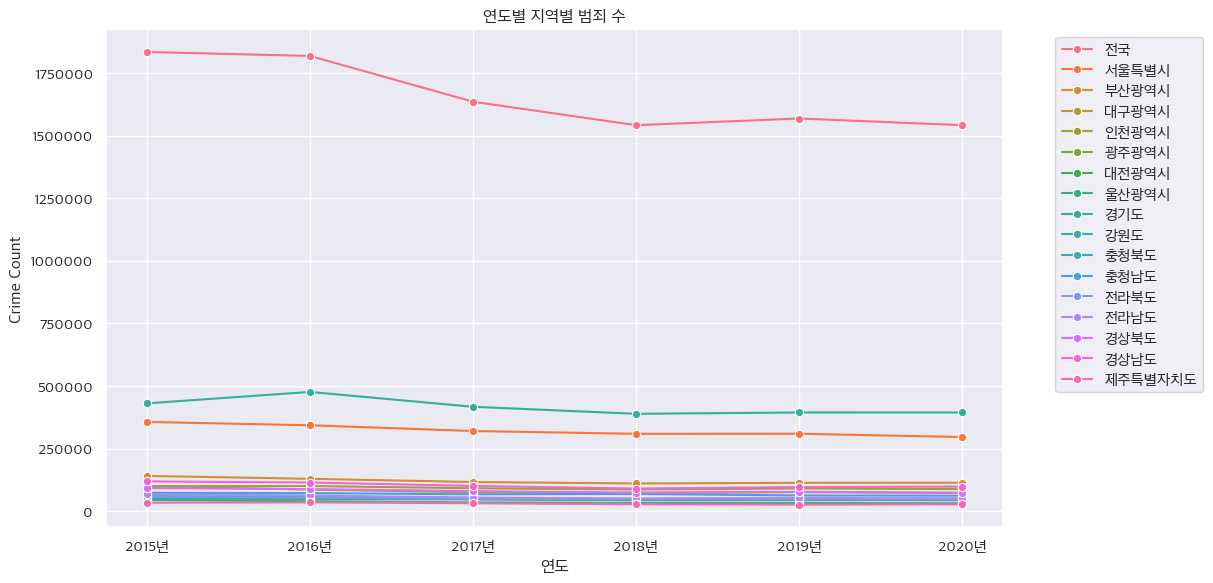

,region,year,crime_count,year_num
0,전국,2015년,1834836,2015
1,서울특별시,2015년,356575,2015
2,부산광역시,2015년,140700,2015
3,대구광역시,2015년,98897,2015
4,인천광역시,2015년,99915,2015
5,광주광역시,2015년,61234,2015
6,대전광역시,2015년,49593,2015
7,울산광역시,2015년,44569,2015
8,경기도,2015년,430790,2015
9,강원도,2015년,56928,2015


In [739]:
# line plot: 연도 변화에 따른 지역별 범죄 수
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# criminal.drop('전국', axis=0, inplace=True)
# criminal.drop('서울특별시', axis=0, inplace=True)
# criminal.drop('경기도', axis=0, inplace=True)

# 1. 기존 행 인덱스를 'region' 열로 변환
# 2. melt로 long-format 변환
cm_long = criminal.reset_index().rename(columns={'index':'region'})
cm_long = cm_long.melt(id_vars='region', var_name='year', value_name='crime_count')

# 연도 숫자 추출(정렬용)
cm_long['year_num'] = cm_long['year'].astype(str).str.extract(r'(\d{4})').astype(int)

# (선택) 그릴 지역 목록 — 주석 해제하고 원하는 지역만 넣으면 됨
# regions_to_plot = ['서울특별시','경기도','부산광역시']
# cm_long = cm_long[cm_long['region'].isin(regions_to_plot)]

# Plot: x=year_num, y=crime_count, hue=region
plt.figure(figsize=(12,6))
sns.lineplot(data=cm_long, x='year_num', y='crime_count', hue='region', marker='o')
plt.xticks(cm_long['year_num'].sort_values().unique(), [str(y)+'년' for y in cm_long['year_num'].sort_values().unique()])
plt.xlabel('연도')
plt.ylabel('Crime Count')
plt.title('연도별 지역별 범죄 수')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.ticklabel_format(style='plain', axis='y')

plt.show()


# 데이터 확인
display(cm_long.head(20))

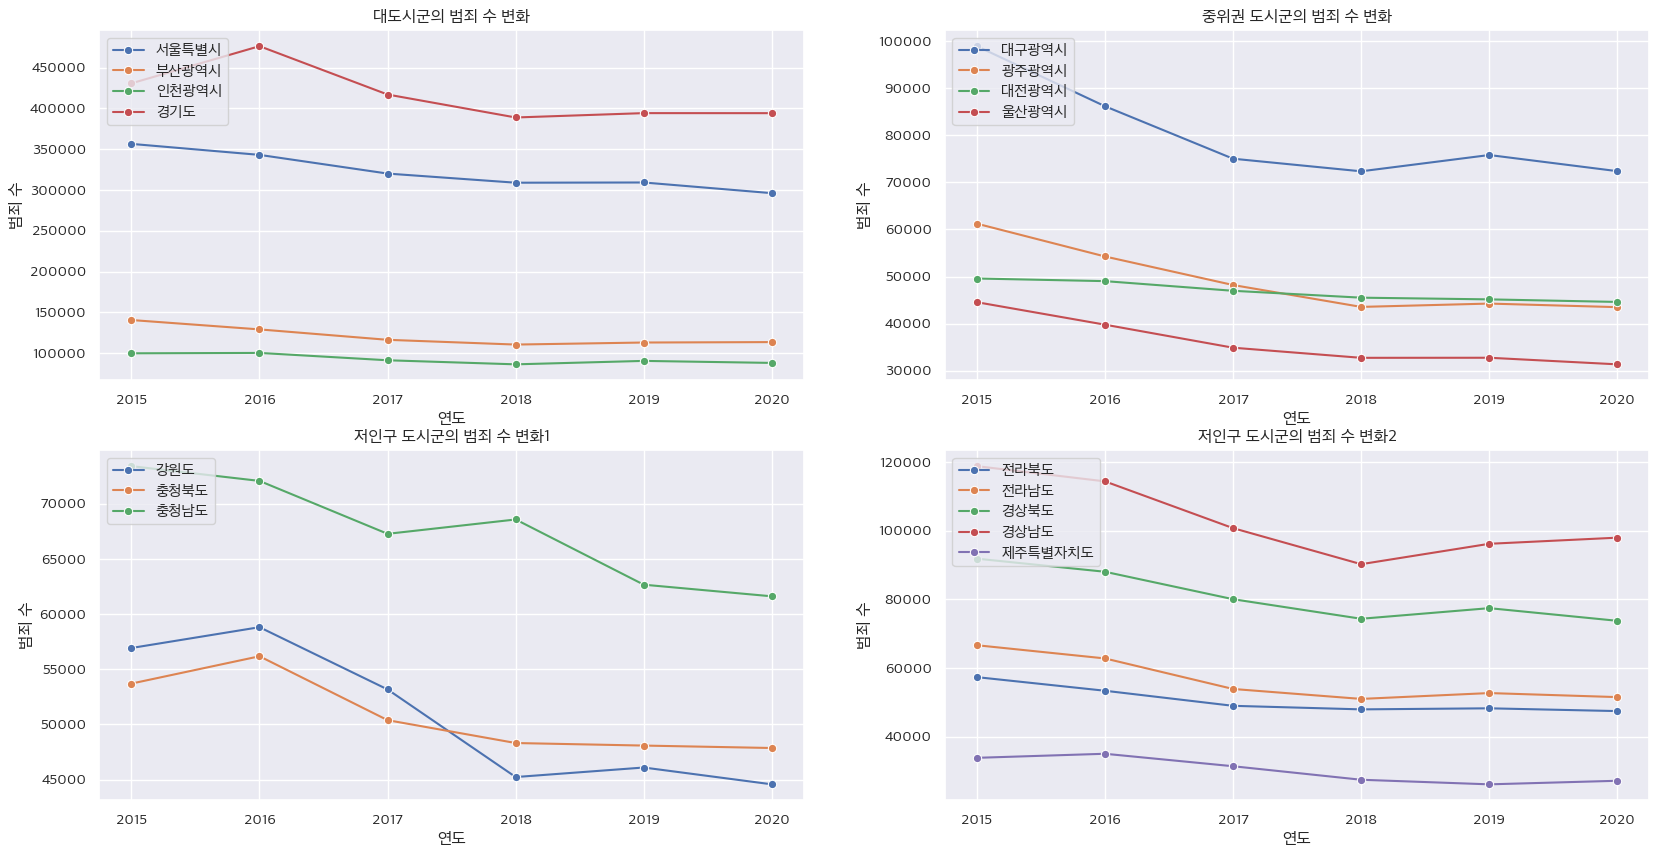

In [740]:
# line plot: 연도 변화에 따른 지역별 범죄 수
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# criminal.drop('전국', axis=0, inplace=True)
# criminal.drop('서울특별시', axis=0, inplace=True)
# criminal.drop('경기도', axis=0, inplace=True)

# 1. 기존 행 인덱스를 'region' 열로 변환
# 2. melt로 long-format 변환
cm_long = criminal.reset_index().rename(columns={'index':'region'})
cm_long = cm_long.melt(id_vars='region', var_name='year', value_name='crime_count')

# 연도 숫자 추출(정렬용)
cm_long['year_num'] = cm_long['year'].astype(str).str.extract(r'(\d{4})').astype(int)

# (선택) 그릴 지역 목록 — 주석 해제하고 원하는 지역만 넣으면 됨
# regions_to_plot = ['서울특별시','경기도','부산광역시']
# cm_long = cm_long[cm_long['region'].isin(regions_to_plot)]

# Plot: x=year_num, y=crime_count, hue=region
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

# 첫 번째 그래프
regions_to_plot = ['서울특별시','경기도','부산광역시', '인천광역시']
cm_long1 = cm_long[cm_long['region'].isin(regions_to_plot)]
sns.lineplot(data=cm_long1, x='year_num', y='crime_count', hue='region', marker='o', ax=ax1)
ax1.set_title('대도시군의 범죄 수 변화')
ax1.set_xlabel('연도')
ax1.set_ylabel('범죄 수')
ax1.legend(loc='upper left')

# 두 번째 그래프
regions_to_plot = ['대구광역시','광주광역시','대전광역시', '울산광역시']
cm_long2 = cm_long[cm_long['region'].isin(regions_to_plot)]
sns.lineplot(data=cm_long2, x='year_num', y='crime_count', hue='region', marker='o', ax=ax2)
ax2.set_title('중위권 도시군의 범죄 수 변화')
ax2.set_xlabel('연도')
ax2.set_ylabel('범죄 수')
ax2.legend(loc='upper left')

# 세 번째 그래프
regions_to_plot = ['강원도','충청북도','충청남도']
cm_long3 = cm_long[cm_long['region'].isin(regions_to_plot)]
sns.lineplot(data=cm_long3, x='year_num', y='crime_count', hue='region', marker='o', ax=ax3)
ax3.set_title('저인구 도시군의 범죄 수 변화1')
ax3.set_xlabel('연도')
ax3.set_ylabel('범죄 수')
ax3.legend(loc='upper left')

# 네 번째 그래프
regions_to_plot = ['전라북도','전라남도','경상북도','경상남도', '제주특별자치도']
cm_long4 = cm_long[cm_long['region'].isin(regions_to_plot)]
sns.lineplot(data=cm_long4, x='year_num', y='crime_count', hue='region', marker='o', ax=ax4)
ax4.set_title('저인구 도시군의 범죄 수 변화2')
ax4.set_xlabel('연도')
ax4.set_ylabel('범죄 수')
ax4.legend(loc='upper left')

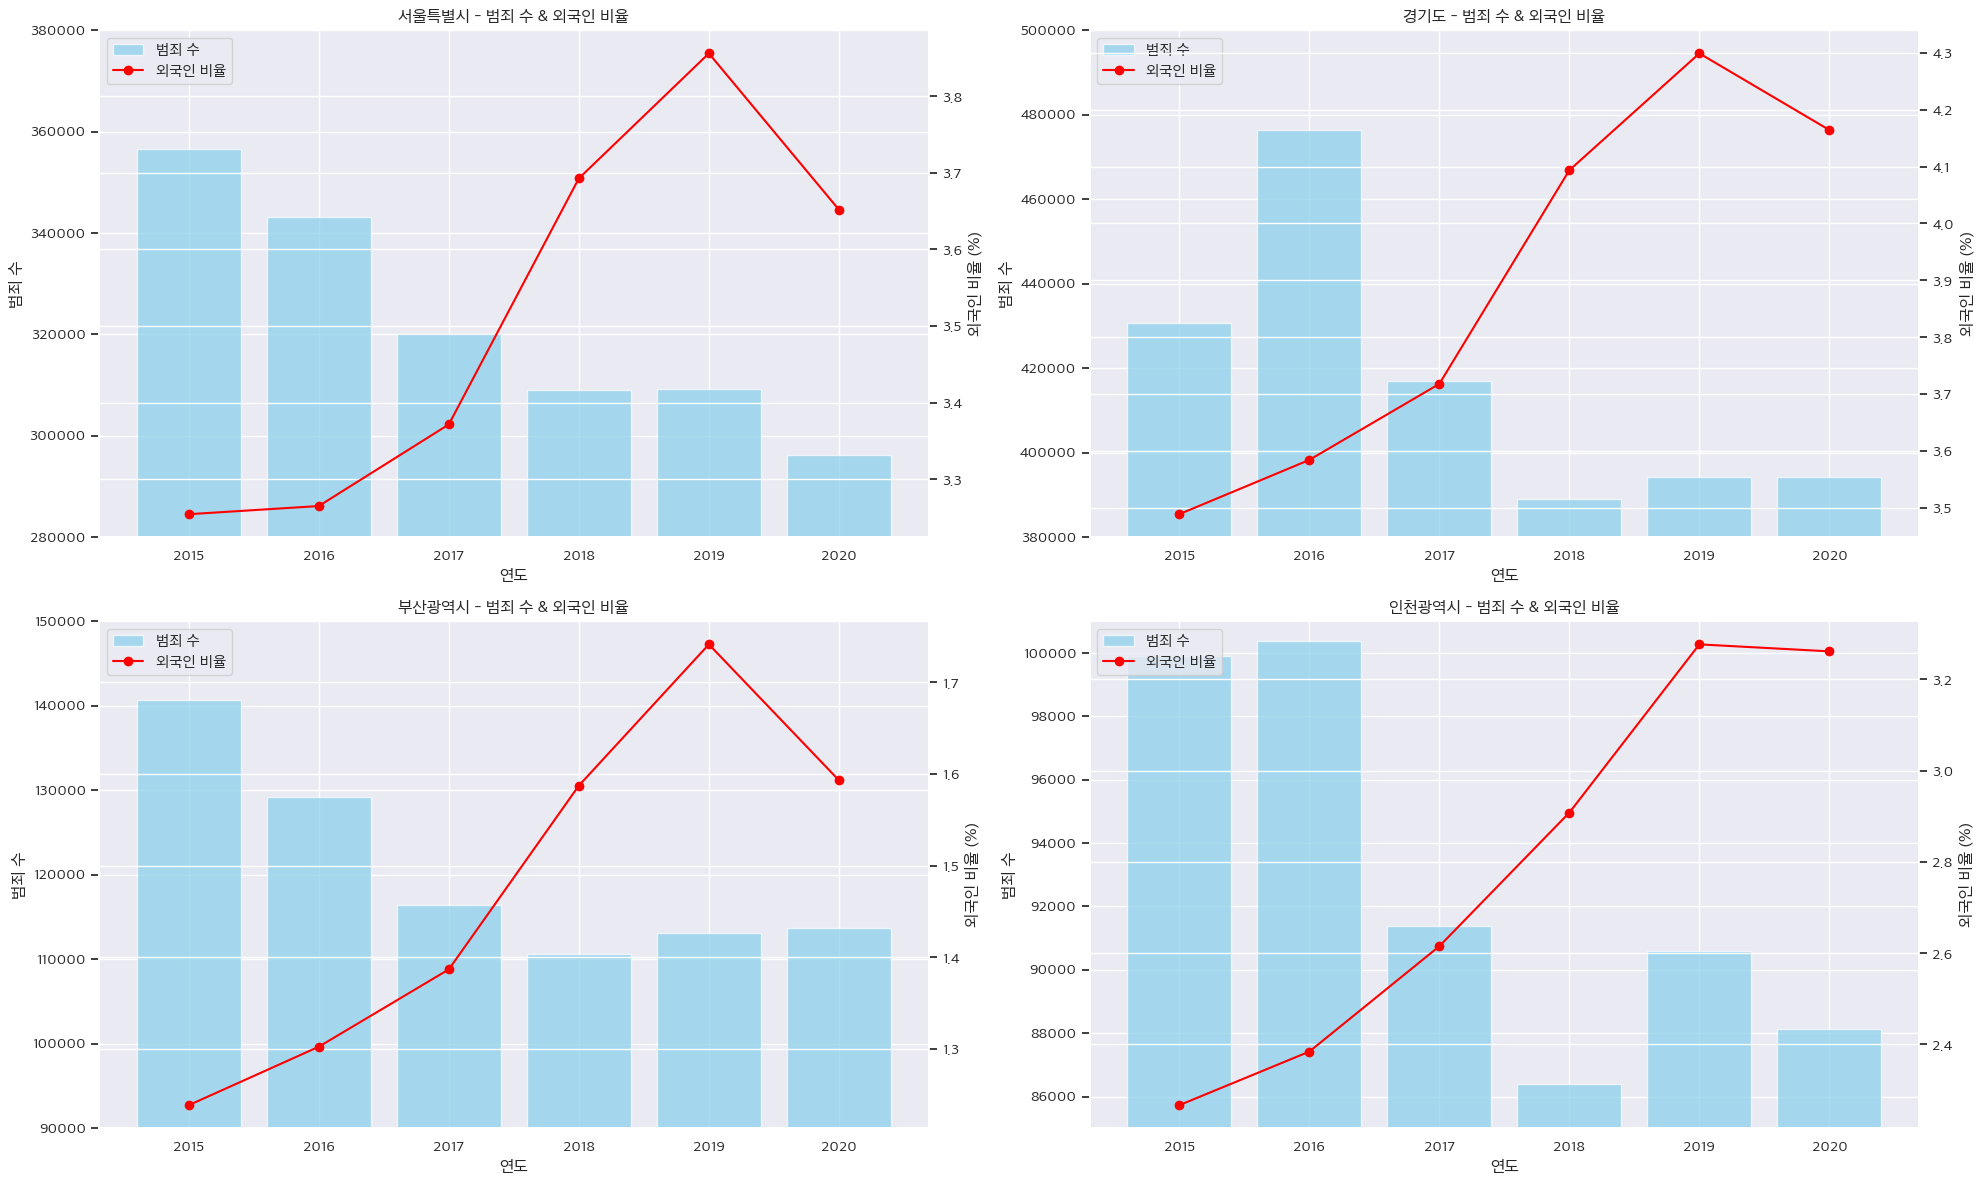

In [741]:
# 복합 그래프: 막대그래프(범죄 수) + 선그래프(외국인 비율)

import matplotlib.pyplot as plt
# ---- 데이터 준비: criminal, foreignerPercent ----
crime_long = criminal.reset_index().rename(columns={'index':'region'})
crime_long = crime_long.melt(id_vars='region', var_name='year', value_name='crime')
crime_long['year_num'] = crime_long['year'].str.extract(r'(\d{4})').astype(int)

fp_long = foreignerPercent.reset_index().rename(columns={'index':'region'})
fp_long = fp_long.melt(id_vars='region', var_name='year', value_name='pct')
fp_long['year_num'] = fp_long['year'].str.extract(r'(\d{4})').astype(int)

# 분석할 지역
regions = ['서울특별시','경기도','부산광역시','인천광역시']

# ---- subplot 만들기 ----
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()

for i, region in enumerate(regions):
    ax = axes[i]
    
    # 지역별 데이터 추출
    c = crime_long[crime_long['region'] == region]
    f = fp_long[fp_long['region'] == region]
    
    # 막대그래프(범죄 수)
    ax.bar(c['year_num'], c['crime'], color='skyblue', alpha=0.7, label='범죄 수')
    ax.set_xlabel('연도')
    ax.set_ylabel('범죄 수')
    ax.set_title(f'{region} - 범죄 수 & 외국인 비율')
    if i==0:
        ax.set_ylim(280000, 380000)
    elif i==1:
        ax.set_ylim(380000, 500000)
    elif i==2:
        ax.set_ylim(90000, 150000)
    elif i==3:
        ax.set_ylim(85000, 101000)
    elif i==4:
        ax.set_ylim(86000, 120000)

    # 선그래프(외국인 비율) — 보조축
    ax2 = ax.twinx()
    ax2.plot(f['year_num'], f['pct'], marker='o', color='red', label='외국인 비율')
    ax2.set_ylabel('외국인 비율 (%)')
    
    # 범례 합치기
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()


In [742]:
# 인구 대비 범죄 수(범죄율)로 지도 만들고, 호버했을 때 외국인 비율이 보이게

cp_df = cp_long.query("region != '전국'").copy()
fp_df = fp_long.query("region != '전국'").copy()

df = pd.merge(cp_df, fp_df[['region','year','pct']], on=['region','year'])
df.rename(columns={'pct':'foreign_ratio'}, inplace=True)

korea_geojson = 'data/skorea-provinces-2018-geo.json'

fig = px.choropleth(
    df,
    geojson=korea_geojson,    # 시/도 경계 GeoJSON
    locations='region',       # 데이터와 GeoJSON 매칭용 컬럼
    featureidkey='properties.name',
    color='criminal_percent',    # 색으로 표시
    hover_data=['foreign_ratio'],
    hover_name='region',
    animation_frame='year'
)

fig.update_geos(fitbounds="locations", visible=False)
fig.show()